In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import os
import PIL
import PIL.Image
import requests
from io import BytesIO
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# load ratings spreadsheet
ratings_df = pd.read_csv("All_Ratings.csv")

In [3]:
ratings_df.head()

,FileName,Rating
0,AF1.jpg,2
1,AF10.jpg,3
2,AF100.jpg,3
3,AF1000.jpg,4
4,AF1001.jpg,4


In [4]:
# before running this cell, make sure you have an Images folder containing 5500 images
# the 5500 images are downloaded from https://drive.google.com/file/d/1w0TorBfTIqbquQVd6k3h_77ypnrvfGwf/view
# see https://github.com/HCIILAB/SCUT-FBP5500-Database-Release for more details

# move images into their classified folders
imageFiles = Path('Images').glob("*.jpg")
for f in imageFiles:
    filename = f.name
    source = f
    rating = ratings_df.loc[ratings_df.FileName == filename, 'Rating'].item()
    destination = Path("Images") / str(rating) / filename
    destination.mkdir(parents=True, exist_ok=True)
    print(destination)
    source.replace(destination)
    

In [5]:
for index, row in ratings_df.iterrows():
    print(row['FileName'])
    print(row['Rating'])
    break
    

AF1.jpg
2


In [6]:
# get rating for file AF1000.jpg
rating = ratings_df.loc[ratings_df.FileName == 'AF1000.jpg', 'Rating'].item()
rating

4

In [7]:
ratings_df.describe()

,Rating
count,5500.000000
mean,3.017636
std,0.735568
min,1.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,5.000000


In [8]:
# print tensorflow version; this notebook is created in tensorflow 2.3
print(tf.__version__)

2.3.0


In [9]:
# set data_dir to the Images folder
data_dir = Path("Images")

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5500


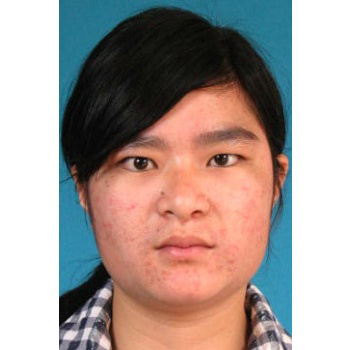

In [11]:
# rating of 1
image1s = list(data_dir.glob('1/*'))
PIL.Image.open(str(image1s[0]))

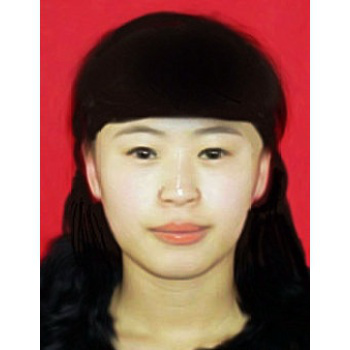

In [12]:
# rating of 2
image2s = list(data_dir.glob('2/*'))
PIL.Image.open(str(image2s[0]))

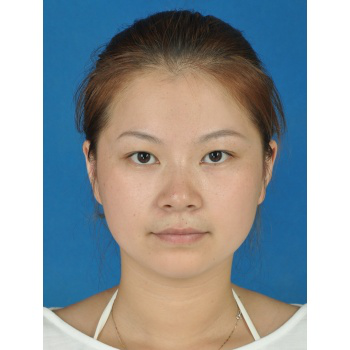

In [13]:
# rating of 3
image3s = list(data_dir.glob('3/*'))
PIL.Image.open(str(image3s[1]))

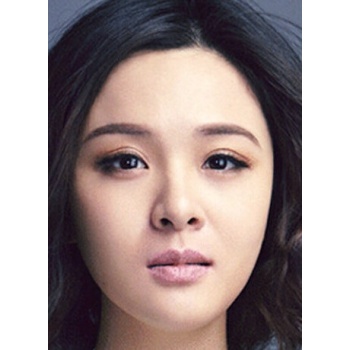

In [14]:
# rating of 4
image4s = list(data_dir.glob('4/*'))
PIL.Image.open(str(image4s[0]))

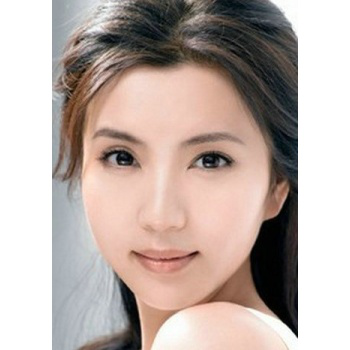

In [15]:
# rating of 5
image5s = list(data_dir.glob('5/*'))
PIL.Image.open(str(image5s[0]))

In [16]:
# Define some parameters for the loader
batch_size = 16
img_height = 350
img_width = 350

In [17]:
# split data 80% training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5500 files belonging to 5 classes.
Using 4400 files for training.


In [18]:
# and 20% validation (test)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5500 files belonging to 5 classes.
Using 1100 files for validation.


In [19]:
# these are the beauty scores, they are extracted from the folder names
class_names = train_ds.class_names
print(class_names)

['1', '2', '3', '4', '5']


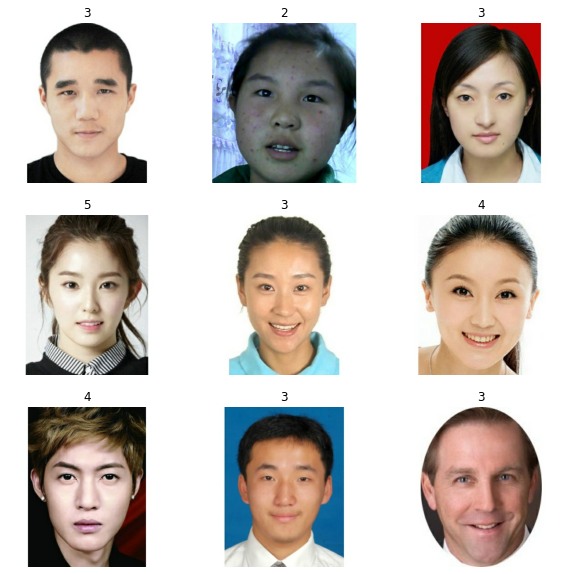

In [20]:
# visualize the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
# check size of one batch from the dataset
# (16, 350, 350, 3): batch size = 16; image is 350 x 350 pixels ; 3: image is RGB color channel
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 350, 350, 3)
(16,)


In [22]:
# scaling
from tensorflow.keras import layers
# include scaling inside model definition

In [23]:
# Configure the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
# Create the model
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
# Compile the model
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [26]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 350, 350, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 350, 350, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 175, 175, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 175, 175, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 87, 87, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 43, 64)        0

In [27]:
# Train the model
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
275/275 [==============================] - 207s 751ms/step - loss: 1.1222 - accuracy: 0.5552 - val_loss: 0.9046 - val_accuracy: 0.6018
Epoch 2/10
275/275 [==============================] - 185s 673ms/step - loss: 0.8525 - accuracy: 0.6139 - val_loss: 0.8657 - val_accuracy: 0.6127
Epoch 3/10
275/275 [==============================] - 181s 657ms/step - loss: 0.7531 - accuracy: 0.6686 - val_loss: 0.9109 - val_accuracy: 0.5636
Epoch 4/10
275/275 [==============================] - 182s 663ms/step - loss: 0.6501 - accuracy: 0.7048 - val_loss: 1.1357 - val_accuracy: 0.5455
Epoch 5/10
275/275 [==============================] - 182s 662ms/step - loss: 0.5403 - accuracy: 0.7682 - val_loss: 1.3785 - val_accuracy: 0.5518
Epoch 6/10
275/275 [==============================] - 180s 656ms/step - loss: 0.4428 - accuracy: 0.8145 - val_loss: 1.4216 - val_accuracy: 0.5473
Epoch 7/10
275/275 [==============================] - 182s 663ms/step - loss: 0.3284 - accuracy: 0.8641 - val_loss: 1.7375 -

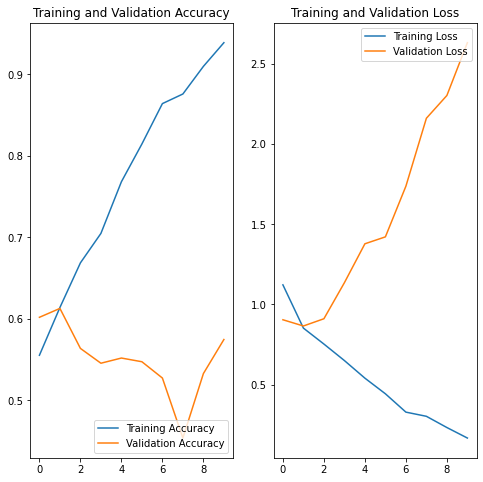

In [28]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

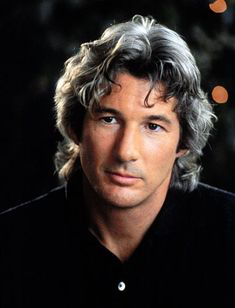

In [29]:
# Predict on new data
rgear_url = "https://i.pinimg.com/236x/a2/4f/35/a24f351c4149f0fc2da71efa77599297.jpg"
response = requests.get(rgear_url)
PIL.Image.open(BytesIO(response.content))

In [30]:
rgear_path = tf.keras.utils.get_file('a24f351c4149f0fc2da71efa77599297', origin=rgear_url)

img = keras.preprocessing.image.load_img(
    rgear_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image has a beauty score of {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image has a beauty score of 4 with a 100.00 percent confidence.


In [31]:
# save the model
import joblib
model.save("beautyScore.h5")

In [32]:
# load the model
from tensorflow.keras.models import load_model
beautyScore_model = load_model("beautyScore.h5")

In [33]:
# Evaluating the loaded model
predictions = beautyScore_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image has a beauty score of {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image has a beauty score of 4 with a 100.00 percent confidence.


In [34]:
# use the loaded model to provide beauty scores to all images in the static/image folder
imageFiles = Path('images-test1').glob("*")
scores = []
fileList = []
for imgPath in imageFiles:
    print(imgPath)
    fileList.append(imgPath)
    PIL.Image.open(str(image1s[0]))
    img = keras.preprocessing.image.load_img(imgPath, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = beautyScore_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    score_py = class_names[np.argmax(score)]
    scores.append(score_py)
    print(f"This image has a beauty score of {score_py} with a {100 * np.max(score):.2f} percent confidence.")

images-test1\Actor.jpg
This image has a beauty score of 4 with a 96.01 percent confidence.
images-test1\AF1844.jpg
This image has a beauty score of 5 with a 100.00 percent confidence.
images-test1\AF66.jpg
This image has a beauty score of 2 with a 78.03 percent confidence.
images-test1\AF788.jpg
This image has a beauty score of 1 with a 99.19 percent confidence.
images-test1\AF885.jpg
This image has a beauty score of 4 with a 90.27 percent confidence.
images-test1\AM1624.jpg
This image has a beauty score of 4 with a 99.46 percent confidence.
images-test1\AM1936.jpg
This image has a beauty score of 5 with a 99.47 percent confidence.
images-test1\baby.jpg
This image has a beauty score of 4 with a 97.98 percent confidence.
images-test1\BillGates.jpg
This image has a beauty score of 4 with a 95.45 percent confidence.
images-test1\CF426.jpg
This image has a beauty score of 3 with a 99.97 percent confidence.
images-test1\CF634.jpg
This image has a beauty score of 2 with a 49.71 percent confi

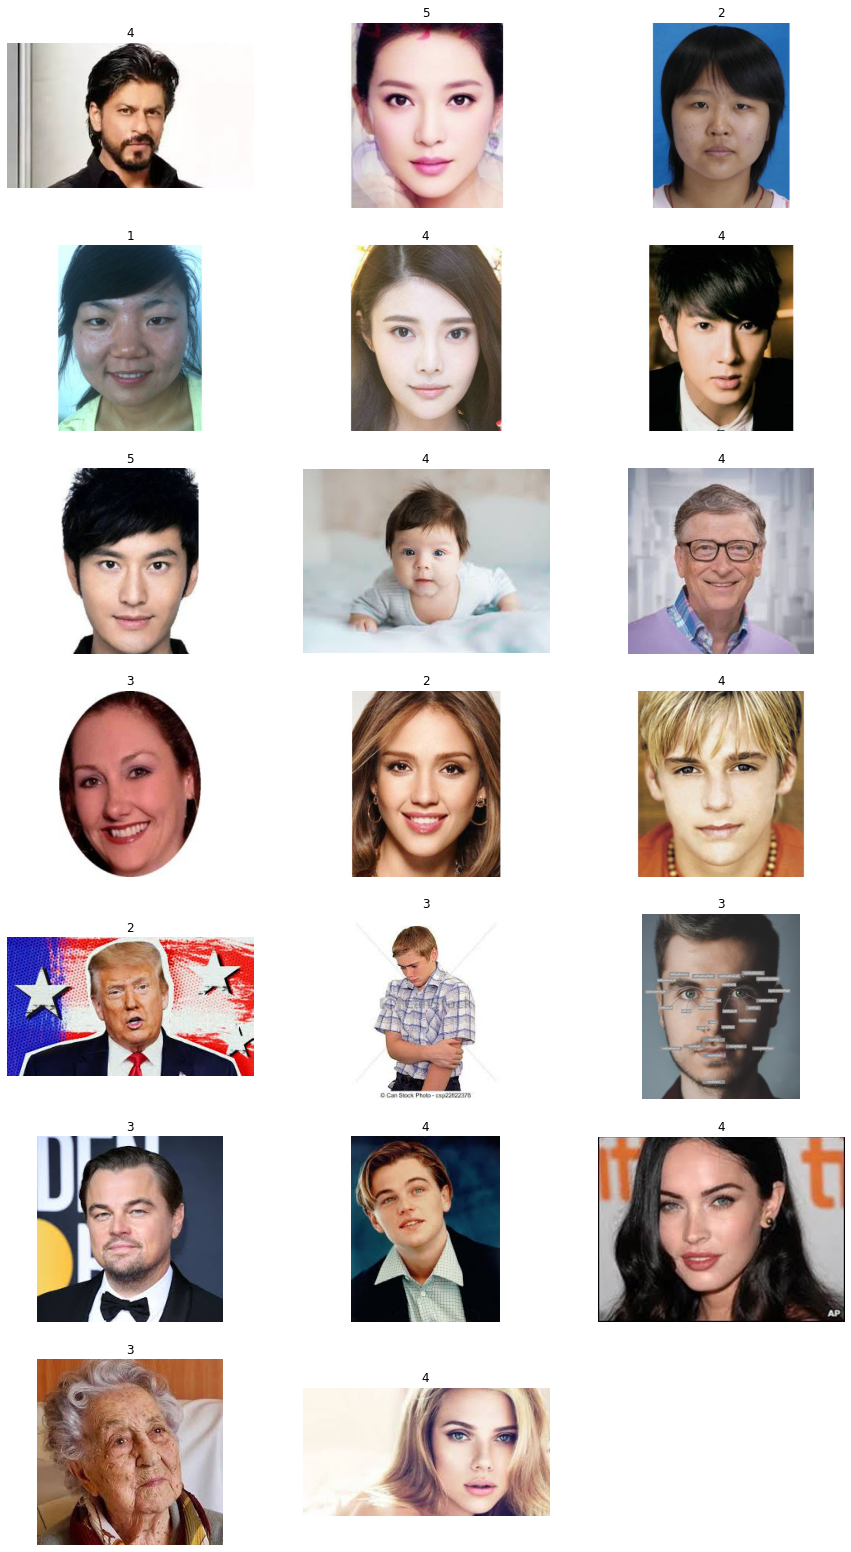

In [35]:
# show all images with their beauty score as title
images_count = len(fileList)
rows = int(images_count/3) + 1
plt.figure(figsize=(15, rows * 4))
for i in range(images_count):
    ax = plt.subplot(rows, 3, i + 1)
    plt.imshow(mpimg.imread(fileList[i]))
    plt.title(scores[i])
    plt.axis("off")

